## Transfer Learning on Cats-Dogs Classification - Feature Extraction

#### Features are extracted from a MobileNet-V2 model pre-trained on ImageNet data, then passed through a new classification head to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### SDSC Summer Institute
Mai H. Nguyen, UC San Diego

-----

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import datetime

In [2]:
print("Tensorflow version:",tf.__version__)
!python --version

Tensorflow version: 2.5.0
Python 3.6.9


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Mon Aug  1 19:20:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Set random generator seed
seed = 1234

#Disable hash randomization by specifying the value 0.
os.environ['PYTHONHASHSEED'] = '0'

# Set numpy random generator
np.random.seed(seed)

# Set python built-in random generator
random.seed(seed)

# set tf global random seed
tf.random.set_seed(seed)

# Set tensorflow graph-level random seed
tf.compat.v1.random.set_random_seed(seed)

#potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [7]:
import os 

USER = os.environ['USER']
SLURM_JOBID = os.environ['SLURM_JOBID']

data_path = '/scratch/' + USER + '/job_' + SLURM_JOBID + '/catsVsDogs'
print (data_path)

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

/scratch/mhnguyen/job_14832705/catsVsDogs
Train path:/scratch/mhnguyen/job_14832705/catsVsDogs/train
Validation path:/scratch/mhnguyen/job_14832705/catsVsDogs/val
Test path:/scratch/mhnguyen/job_14832705/catsVsDogs/test


In [8]:
# Image dimensions
img_width, img_height = 224,224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

### Prepare data

In [9]:
# Batch size
BATCH_SIZE = 16

# Data augmentation setup
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(train_data_dir,target_size=IMG_SIZE,
                                              batch_size = BATCH_SIZE, class_mode='binary', 
                                              shuffle = True, seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(val_data_dir,target_size=IMG_SIZE,
                                                   batch_size = BATCH_SIZE,class_mode='binary',
                                                   shuffle = False, seed = seed)
# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=IMG_SIZE,
                                             batch_size = BATCH_SIZE, class_mode='binary',
                                             shuffle = False, seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load pre-trained model

In [10]:
#Load pre-trained model's Imagenet weights not including the fully connected layers
base_model = applications.MobileNetV2(include_top = False, weights = 'imagenet', input_shape=IMG_SHAPE)

# Freeze all weights of pre-trained model
base_model.trainable = False

# Needed to keep BatchNormalization layers in inference mode for pre-trained model. 
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization 
base_model.training  = False

# Look at pre-trained model's architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Create top model

In [11]:
img_inputs = tf.keras.Input(shape=(img_width, img_height, 3))
base_outputs = base_model(img_inputs)

GlobalAveragePooler2D = GlobalAveragePooling2D()
GlobalAveragePooler2D_outputs = GlobalAveragePooler2D(base_outputs)

Dropper = Dropout(0.2)
DroppedOut_outputs = Dropper(GlobalAveragePooler2D_outputs)

DenseLayer = Dense(1, activation='sigmoid')
outputs = DenseLayer(DroppedOut_outputs)

model = tf.keras.Model(inputs=img_inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Train top model

In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

In [14]:
%%time

# Train top model for 5 epochs
EPOCHS = 5

train_history = model.fit(train_generator,validation_data=validation_generator, epochs=EPOCHS)

Epoch 1/5
125/125 [==============================] - 26s 148ms/step - loss: 0.5694 - accuracy: 0.7170 - val_loss: 0.3768 - val_accuracy: 0.8900
Epoch 2/5
125/125 [==============================] - 18s 144ms/step - loss: 0.3224 - accuracy: 0.9105 - val_loss: 0.2345 - val_accuracy: 0.9425
Epoch 3/5
125/125 [==============================] - 18s 145ms/step - loss: 0.2259 - accuracy: 0.9365 - val_loss: 0.1706 - val_accuracy: 0.9625
Epoch 4/5
125/125 [==============================] - 18s 144ms/step - loss: 0.1744 - accuracy: 0.9560 - val_loss: 0.1365 - val_accuracy: 0.9775
Epoch 5/5
125/125 [==============================] - 18s 144ms/step - loss: 0.1440 - accuracy: 0.9690 - val_loss: 0.1155 - val_accuracy: 0.9800
CPU times: user 1min 40s, sys: 5.13 s, total: 1min 45s
Wall time: 1min 39s


In [15]:
# Save weights from trained model
model.save("models/features_model")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


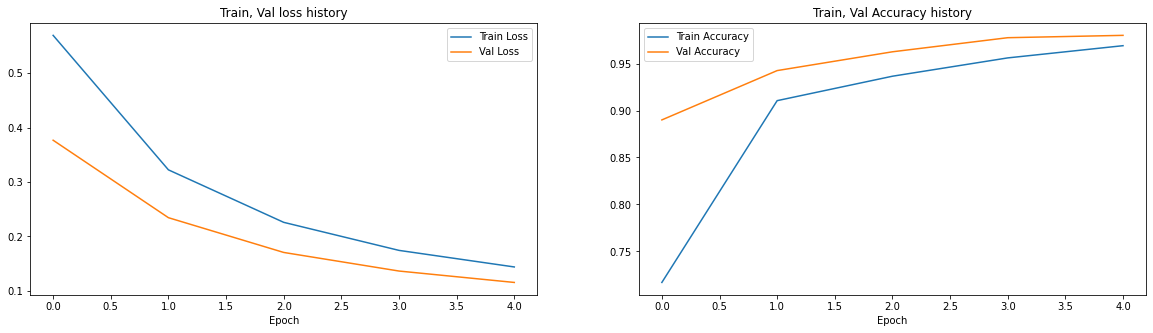

In [16]:
# Plot train and validation history
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluation and Inference

In [17]:
# Get train data accuracy
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

# Get test data accuracy
_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 17s 137ms/step - loss: 0.1298 - accuracy: 0.9675
Train data accuracy: 0.9674999713897705
25/25 [==============================] - 1s 36ms/step - loss: 0.1250 - accuracy: 0.9775
Test data accuracy: 0.9775000214576721


In [18]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

In [19]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs'], digits=4))

              precision    recall  f1-score   support

        cats     0.9799    0.9750    0.9774       200
        dogs     0.9751    0.9800    0.9776       200

    accuracy                         0.9775       400
   macro avg     0.9775    0.9775    0.9775       400
weighted avg     0.9775    0.9775    0.9775       400



### Perform inference on test images

In [20]:
def image_loader(img_file):
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    # img = img_to_array(img) / 255
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,width,height,channels)
    return img

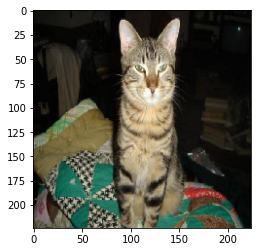

[[0.12273]]


In [21]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

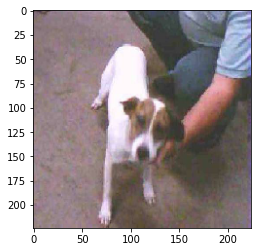

[[0.95848]]


In [22]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

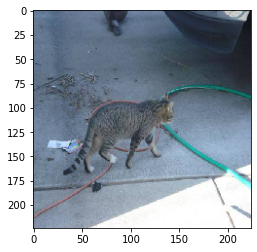

[[0.59809]]


In [23]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

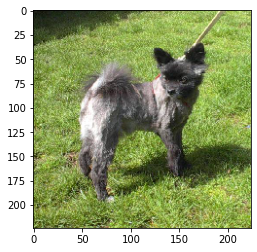

[[0.4241]]


In [24]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

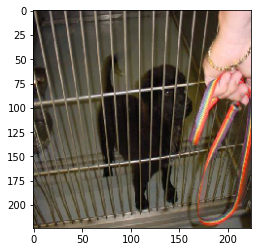

[[0.6163]]


In [25]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))